# CSCA 5642 Introduction to Deep Learning Week 5 Homework

## Preparation

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

%matplotlib inline

import PIL
from PIL import Image
import shutil

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [24]:
project_root = '/home/lee/Documents/CSCA5642/week5/'
data_folder = os.path.join(project_root, 'gan-getting-started')

## Description of the problem and data

Data source: https://www.kaggle.com/competitions/gan-getting-started

We are provided images files that are Monet paintings and other photos. The task is to build a generative adversarial network (GAN) that generates 7,000 to 10,000 Monet-style images.

### Data size, dimension, structure

Instead of relying on EDA to find out some basic information about the input data, the author of the dataset provided us the necessary info
* the dataset contains 300 Monet paintings and 7028 photos
* image size is 256x256
* the image files are in JPEG format - the monet_jpg and photo_jpg folders contain JPEG files directly, and the monet_tfrec and photo_tfrec folders contain TFRecord format, inside which there are JPEG files

In [49]:
monet_files = tf.io.gfile.glob(os.path.join(data_folder, 'monet_tfrec/*.tfrec'))
photo_files = tf.io.gfile.glob(os.path.join(data_folder, 'photo_tfrec/*.tfrec'))

In [26]:
IMAGE_SIZE = [256, 256]

def decode_img(image): 
    # note that what is inside the TFRecord files are jpeg files
    image = tf.image.decode_jpeg(image, channels=3)
    # convert the pixel values in range [-1,1]
    image = (tf.cast(image, tf.float32) / 255) * 2 - 1 
    # reshape the image to proper size
    image = tf.reshape(image, shape=[*IMAGE_SIZE, 3])  
    return image

# extract image from TFRecord format
def read_tfrec(example):  
    tfrec_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),  # [] denotes fixed length feature where length=1
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    image = decode_img(example['image'])
    return image

In [27]:
def load_data(files):
    data = tf.data.TFRecordDataset(files)
    data = data.map(read_tfrec)
    return data

In [28]:
# forming batches of size=1 (i.e. 1 image processed at a time)
monet_data = load_data(monet_files).batch(1)                      
photo_data = load_data(photo_files).batch(1)

### Inspect the images

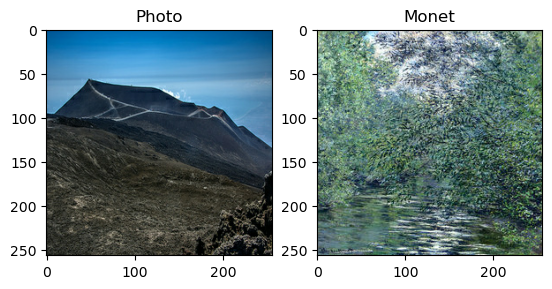

In [29]:
ex_monet = next(iter(monet_data))
ex_photo = next(iter(photo_data))

plt.subplot(1, 2, 1)
plt.title('Photo')
plt.imshow(ex_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title('Monet')
plt.imshow(ex_monet[0] * 0.5 + 0.5)                   

## Model architecture

In general, a GAN model has two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.

In this project, we will build a CycleGAN. It is a GAN architecture primarily being used to learn transformation between images of different styles. Compared to a regular DCGAN, which typically consists of a generator model and a discriminator model, CycleGAN consists of two generator-discriminator pairs, each dedicated to translating images from one domain to the other and vice versa. Additionally, it includes cycle-consistency loss terms to enforce the consistency between the original and reconstructed images in both domains.

The discriminator is a deep convolutional neural network that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is a real or fake image. Two discriminator models are used, one for Monet style and one for photos.

The generator is an encoder-decoder model architecture. The model takes a source image and generates a target image. It does this by first downsampling the input image down to a bottleneck layer, then interpreting the encoding with a number of convolutional layers that use skip connections, followed by a series of layers that upsample the representation to the size of the output image.

The function of down-sampling is feature extraction. It helps to reduce the spatial dimensions of the input image, effectively summarizing the important features while discarding some of the finer details. Our down-sampling is performed through strided convolutions, though other operations like max-pooling are typically used too. 

Up-sampling helps to increase the resolution of lower-resolution images to match the desired output size.

When reading literature, we learned that unlike other models, CycleGAN uses InstanceNormalization layers instead of BatchNormalization layers. Tensorflow implements InstanceNormalization using its GroupNormalization layers.

In [30]:
def downsample(filters, size, instance_norm=True):
    # for extracting features (size is reduced)
    initializer = tf.random_normal_initializer(0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    
    model = keras.Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if instance_norm:
        model.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))  # groups=-1 to make it work like Instance Normalization
    
    model.add(LeakyReLU())
    
    return model

In [31]:
def upsample(filters, size, dropout=False): 
    initializer = tf.random_normal_initializer(0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    
    model = keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

In [32]:
def generator():
    down_stack = [
        downsample(64, 4, False),  # size = (128, 128, 64) (size denotes the dimensions of image after the corresponding layer/operation)
        downsample(128, 4),  # size = (64, 64, 128)
        downsample(256, 4),  # size = (32, 32, 256)
        downsample(512, 4),  # size = (16, 16, 512)
        downsample(512, 4),  # size = (8, 8, 512)
        downsample(512, 4),  # size = (4, 4, 512)
        downsample(512, 4),  # size = (2, 2, 512)
        downsample(512, 4),  # size = (1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, True),  # size = (2, 2, 1024) (number of channels doubled because upsample block concats output of last downsample block)
        upsample(512, 4, True),  # size = (4, 4, 1024)
        upsample(512, 4, True),  # size = (8, 8, 1024)
        upsample(512, 4),  # size = (16, 16, 1024) (dropout = false so that information is maintained for generating detailed outputs)
        upsample(256, 4),  # size = (32, 32, 512)
        upsample(128, 4),  # size = (64, 64, 256)
        upsample(64, 4),  # size = (128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0, 0.02)
    last_layer = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # 3 output channels required
    
    i = Input(shape=[256, 256, 3])  # input layer
    x = i
    skips = []
    for down in down_stack:  # downsampling
        x = down(x) 
        skips.append(x)  # appending skip connections to the 'skips' list
        
    skips = reversed(skips[:-1])  # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack, skips):  # upsampling and concatenating output with skip connection
        x = up(x)
        x = Concatenate()([x, skip])
        
    x = last_layer(x)  # last layer (Conv2DTranspose) for generating the final output 
    
    model = Model(i, x)
    
    return model

In [33]:
def discriminator():
    i = Input(shape=[256, 256, 3])
    x = downsample(64, 4)(i)  # size = (128, 128, 64)
    x = downsample(128, 4)(x)  # size = (64, 64, 128)
    x = downsample(256, 4)(x)  # size = (32, 32, 256)

    x = ZeroPadding2D()(x)  # size = (34, 34, 256) (1 pixel padding is added at top, bottom, left, right)

    initializer = tf.random_normal_initializer(0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    x = Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)  # size = (31, 31, 512) (size = orig - kernel + 1)
    x = GroupNormalization(groups=-1, gamma_initializer=gamma_init)(x)
    x = LeakyReLU()(x)

    x = ZeroPadding2D()(x)  # size = (33, 33, 512) (zero padding applied to maintain spatial information)

    x = Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)  # size = (30, 30, 1)

    model = Model(i, x)  # (more numerically stable during training)

    return model

In [34]:
monet_generator= generator()
monet_discriminator= discriminator()
photo_generator= generator()
photo_discriminator= discriminator()

In [35]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        # 'lambda_cycle' controls the importance of cycle consistency loss
        lambda_cycle = 10                           
    ):
        # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        super(CycleGAN,self).__init__()            

        # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_gen = monet_gen                      
        self.m_disc = monet_disc
        self.p_gen = photo_gen
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile() 

        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):
        real_monet, real_photo = batch_data

        # to keep a track of operations (persistent = True because there are multiple calls to Gradient())
        with tf.GradientTape(persistent = True) as tape:             

            # photo to monet and then cycled back to photo
            fake_monet = self.m_gen(real_photo, training = True)      
            cycled_photo = self.p_gen(fake_monet, training = True)

            # monet to photo and then cycled back to monet
            fake_photo = self.p_gen(real_monet, training = True)      
            cycled_monet = self.m_gen(fake_photo, training = True)

            # generating itself (useful in calculating identity loss)
            same_photo = self.p_gen(real_photo, training = True)      
            same_monet = self.m_gen(real_monet, training = True)      
            
            disc_real_photo = self.p_disc(real_photo, training = True)   
            disc_real_monet = self.m_disc(real_monet, training = True)   
            
            disc_fake_photo = self.p_disc(fake_photo, training = True)  
            disc_fake_monet = self.m_disc(fake_monet, training = True)
            
            gen_monet_loss = self.gen_loss_function(disc_fake_monet) 
            gen_photo_loss = self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) \
                                + self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss = (gen_monet_loss + total_cycle_loss \
                                    + self.identity_loss_function(real_monet, same_monet, self.lambda_cycle))  
            
            total_gen_photo_loss = (gen_photo_loss + total_cycle_loss \
                                    + self.identity_loss_function(real_photo, same_photo, self.lambda_cycle))
            
            disc_monet_loss = self.disc_loss_function(disc_real_monet, disc_fake_monet)  
            disc_photo_loss = self.disc_loss_function(disc_real_photo, disc_fake_photo)          
            
            
        gen_monet_gradients = tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)      
        gen_photo_gradients = tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)      
        
        disc_monet_gradients = tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)     
        disc_photo_gradients = tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))     
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))     
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

In [36]:
def gen_loss_fn(generated):
    return BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [37]:
def disc_loss_fn(real, generated):
    loss_real = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss = (loss_real + loss_fake) / 2
        
    return total_loss

In [38]:
def cycle_loss_fn(real, cycled, lambda_cycle):
    
    loss = tf.reduce_mean(tf.abs(real - cycled))
    
    # lambda controls the weight of cycle consistency loss in overall loss         
    return lambda_cycle*loss                        

In [39]:
def identity_loss_fn(real, same, Lambda): 
    loss= tf.reduce_mean(tf.abs(real - same))
    # factor of '0.5' used for normalization purposes
    return Lambda*loss*0.5                          

In [40]:
m_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
m_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

p_gen_opt = Adam(learning_rate=2e-4, beta_1=0.5)
p_disc_opt = Adam(learning_rate=2e-4, beta_1=0.5)

In [41]:
cyclegan_model = CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, \
                       cycle_loss_fn, identity_loss_fn)

## Results

In [42]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs=50)

Epoch 1/50


2024-02-27 19:12:34.194704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_10/dropout_2/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-27 19:12:36.595741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-27 19:12:38.123016: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 19:12:38.145639: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

300/300 [==============================] - 124s 338ms/step - gen_monet_loss: 5.1852 - gen_photo_loss: 5.3213 - disc_monet_loss: 0.6327 - disc_photo_loss: 0.6172


2024-02-27 19:14:24.056113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9566302057744731045
2024-02-27 19:14:24.056139: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13094292114599300806


Epoch 2/50
300/300 [==============================] - 106s 353ms/step - gen_monet_loss: 3.7146 - gen_photo_loss: 4.0314 - disc_monet_loss: 0.6648 - disc_photo_loss: 0.5199
Epoch 3/50
300/300 [==============================] - 109s 363ms/step - gen_monet_loss: 3.6176 - gen_photo_loss: 3.9178 - disc_monet_loss: 0.6764 - disc_photo_loss: 0.5626
Epoch 4/50
300/300 [==============================] - 107s 358ms/step - gen_monet_loss: 3.4567 - gen_photo_loss: 3.7601 - disc_monet_loss: 0.6825 - disc_photo_loss: 0.6170
Epoch 5/50
300/300 [==============================] - 107s 358ms/step - gen_monet_loss: 3.2479 - gen_photo_loss: 3.5422 - disc_monet_loss: 0.6883 - disc_photo_loss: 0.6203
Epoch 6/50
300/300 [==============================] - 109s 362ms/step - gen_monet_loss: 3.0761 - gen_photo_loss: 3.2795 - disc_monet_loss: 0.6786 - disc_photo_loss: 0.6293
Epoch 7/50
300/300 [==============================] - 106s 352ms/step - gen_monet_loss: 3.0090 - gen_photo_loss: 3.2098 - disc_monet_loss: 0

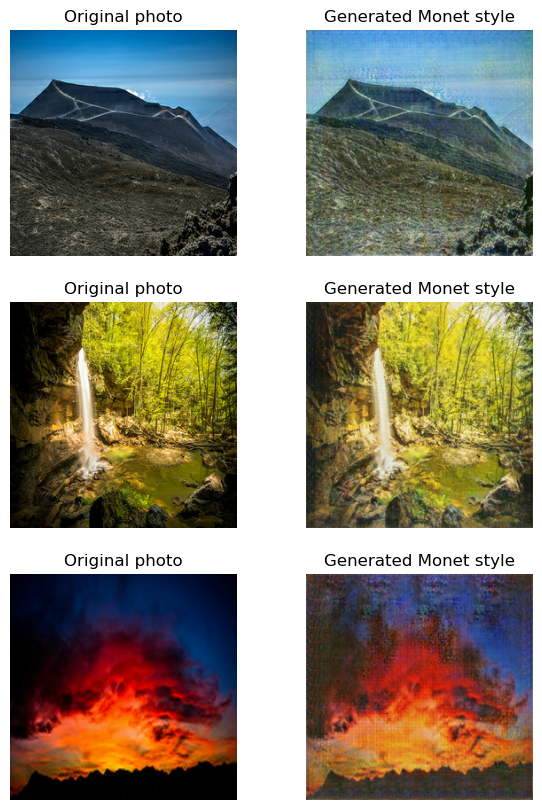

In [50]:
num_pairs = 3
fig, ax = plt.subplots(num_pairs, 2, figsize=(7, 10))
for i, img in enumerate(photo_data.take(num_pairs)):
    pred = monet_generator(img, training=False)[0].numpy()  # training=False -> not to update model weights
    pred = (pred * 127.5 + 127.5).astype(np.uint8)  # making pixel range to [0, 255]
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(pred)
    ax[i, 0].set_title('Original photo')
    ax[i, 1].set_title('Generated Monet style')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

## Conclusion

In [44]:
!mkdir submission_images

In [ ]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("submission_images/" + str(i) + ".jpg")
    i += 1

# shutil.make_archive(os.path.join(project_root, "images"), 'zip', os.path.join(project_root, 'submission_images'))